## Stock prices - Scraping

Done by Wieland Vandebotermet

First We Have 3 models: an Individual model, An timeseries Pycaret Model and a AWS DeepAR Model.

Please not the AWS model training part does not work here locally.

## The Required Imports & Venv

python3.10 -m venv StockPrediction

In [6]:
# %pip install pandas numpy scikit-learn tensorflow pycaret matplotlib

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from io import StringIO
import re

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting.data.examples import get_stallion_data
from pytorch_forecasting import TimeSeriesDataSet

In [8]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from pycaret.time_series import *
from pycaret.utils.time_series import clean_time_index

In [9]:
#import sagemaker
#from sagemaker.estimator import Estimator
#from sagemaker.transformer import Transformer
#from sagemaker.inputs import TrainingInput
#from sagemaker import get_execution_role

#import boto3

# 1. The Individual Model

## Choosing the model

When searching for a model suited for this task the only recommendend model type i could find was LSTM. When searching for a few others i couln't really find much else suited for the task. With nothing better suited To the Task.

1. Long Short-Term Memory (LSTM) Neural Networks:

    * Why LSTM?
        * LSTMs are specifically designed to handle sequential data like stock prices, where the order of data points matters.
        * They are capable of learning patterns over time and can manage dependencies from the past.
        * Stock prices often involve trends and seasonality, which LSTMs can capture effectively.
    * How does it do this:
        * Uses input gates, forget gates, and output gates to decide which information to keep or discard.
        Wich allow it to dynamically adapt to varying time dependencies in the data.

2. Linear Regression with Feature Engineering:

    * Why Linear Regression?
        * A simpler, interpretable approach that works well for basic predictions if the dataset isn’t highly complex.
        * You can create features like daily price changes, moving averages, or relative price differences between the two companies to predict the price movement of one based on the other.
    * How does it do this:
        * Linear regression assumes a linear relationship between the target variable and the predictor variables​. The model estimates the coefficients.
        * Feature engineering involves creating new input features or transforming existing ones to better capture patterns and relationships in the data.

3. ARIMA (AutoRegressive Integrated Moving Average):

    * Why ARIMA?
        * Ideal for univariate time-series forecasting when the focus is on one company’s historical stock data.
        * Can help you project near-term prices for one company, which can then inform predictions about the other company.
    * How does it do this:
        * AutoRegression (AR) captures the relationship between the current value and a series of past values (lags) and uses the lagged version of the target variable as input predictors.
        * Integration (I) makes the data stationary by differencing it (subtracting past values).
        * Moving Average (MA) models the relationship between the current value and past forecast errors (residuals).

## Building The Model

In [10]:
AMD = pd.read_csv('./Data/AMD_CleanedDaily.csv', parse_dates=['datetime'], index_col='datetime')
Intel = pd.read_csv('./Data/Intel_CleanedDaily.csv', parse_dates=['datetime'], index_col='datetime')

# Merge datasets on datetime
data = pd.merge(AMD, Intel, left_index=True, right_index=True, suffixes=('_amd', '_intel'))

# Define target and features
target = 'adj_close_amd'  # Predict chosen companies's adj_close

features = data.columns.drop(target)  # Use all other columns as features

In [11]:
# Normalize the features and target
scalers = {}
scaled_data = pd.DataFrame(index=data.index)

# Normalize each column
for col in data.columns:
    scalers[col] = MinMaxScaler(feature_range=(0, 1))
    scaled_data[col] = scalers[col].fit_transform(data[col].values.reshape(-1, 1))

# Prepare sequences with AMD and Intel features
def create_sequences(data, target_col, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data.iloc[i-sequence_length:i].values)  # All features
        y.append(data.iloc[i][target_col])  # Target column
    return np.array(x), np.array(y)

sequence_length = 60

# Split the data into training and testing sets
# Reserve the last month as the test set
last_month_index = -30  # Assuming daily data; adjust for your frequency
train_data = scaled_data.iloc[:last_month_index]
test_data = scaled_data.iloc[last_month_index - sequence_length:]  # Include sequence length for context

x_train, y_train = create_sequences(train_data, target, sequence_length)
x_test, y_test = create_sequences(test_data, target, sequence_length)

# Reshape for LSTM (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [12]:
# Define the LSTM model with Input
model = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),  # Explicitly define the input shape
    LSTM(units=100, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    LSTM(units=100, return_sequences=False),
    Dropout(0.2),
    Dense(units=50),
    Dense(units=1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

## Train the model

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 0.1034 - val_loss: 0.0118
Epoch 2/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 3/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 4/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 5/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 6/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 7/25
303/303 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 9.8881e-04 - val_loss: 0.0023


## Evaluating the model

In [14]:
# Evaluate the model
train_loss = model.evaluate(x_train, y_train)
test_loss = model.evaluate(x_test, y_test)
print(f"Train Loss: {train_loss}, Test Loss: {test_loss}")

y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae}, RMSE: {rmse}')

303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0012
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0021
Train Loss: 0.0017109275795519352, Test Loss: 0.002071498427540064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
MAE: 0.03557946989343259, RMSE: 0.041959566996991375


## Predicting Stock Prices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


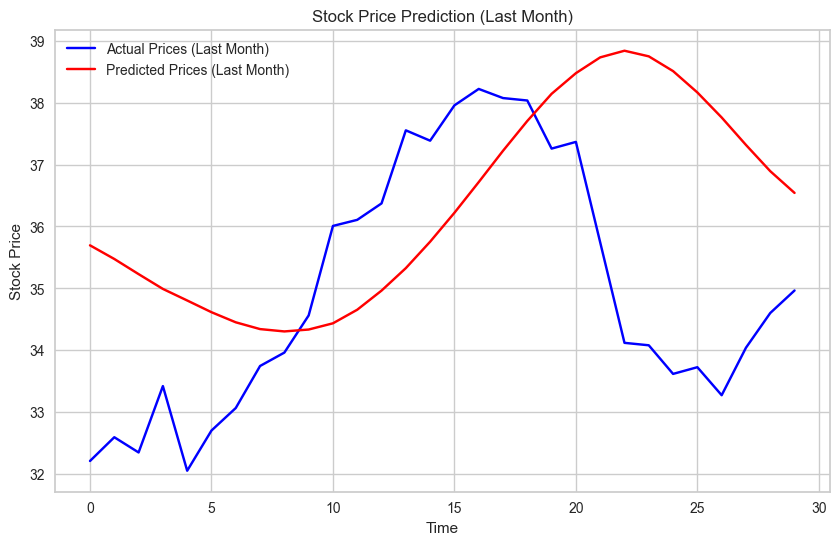

In [15]:
# Predict for the last month
predictions = model.predict(x_test)
predictions_LSTM = scalers[target].inverse_transform(predictions)
y_test_actual = scalers[target].inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Prices (Last Month)')
plt.plot(predictions_LSTM, color='red', label='Predicted Prices (Last Month)')
plt.title('Stock Price Prediction (Last Month)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Saving the model

In [16]:
#model.save('./Models/STLMPredictAMDStockPrice.keras')

# 2 Pycaret Model

## Setting up the data

In [ ]:
# Load the datasets
AMD = pd.read_csv('./Data/AMD_CleanedDaily.csv', parse_dates=['datetime'])
Intel = pd.read_csv('./Data/Intel_CleanedDaily.csv', parse_dates=['datetime'])

# Set datetime as the index
AMD.set_index('datetime', inplace=True)
Intel.set_index('datetime', inplace=True)

# Merge datasets on datetime index
data = pd.merge(AMD, Intel, left_index=True, right_index=True, suffixes=('_amd', '_intel'))

# Train-test split: reserve the last month for testing
train_data = data.iloc[:-30]  # Training data (all but the last 30 rows)
test_data = data.iloc[-30:]   # Testing data (the last 30 rows)

# Convert indices to datetime and set frequency explicitly
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)

# Ensure the datetime index has a consistent frequency (e.g., daily)
train_data.index = train_data.index.to_period('D')
test_data.index = test_data.index.to_period('D')

# Fill missing values with the mean of each column
train_data = train_data.fillna(train_data.mean())
test_data = test_data.fillna(test_data.mean())

train_data = clean_time_index(data=train_data, freq='D')
test_data = clean_time_index(data=test_data, freq='D')

## The Model Building and Training

In [19]:
exogenous_features = [
    'adj_close_amd', 'close_amd', 'high_amd', 'low_amd', 'open_amd', 'volume_amd', 
    'close_intel', 'high_intel', 'low_intel', 'open_intel', 'volume_intel'
]

# PyCaret setup
exp = setup(
    data=train_data,
    target='adj_close_amd',  # The target variable for forecasting
    fh=30,  # Forecast horizon of 30 days
    session_id=369,
    seasonal_period=7,
    numeric_imputation_target='mean',
    numeric_imputation_exogenous='mean',
)

# Compare models and choose the best one
best_model = exp.compare_models(errors="raise")

# Finalize the model
final_model = exp.finalize_model(best_model)

,Description,Value
0,session_id,369
1,Target,adj_close_amd
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(14107, 12)"
5,Transformed data shape,"(14107, 12)"
6,Transformed train set shape,"(14077, 12)"
7,Transformed test set shape,"(30, 12)"
8,Rows with missing values,31.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.0232,0.0113,0.0198,0.0354,0.0012,0.0012,1.0000,5.1767
auto_arima,Auto ARIMA,0.0232,0.0113,0.0198,0.0354,0.0012,0.0012,1.0000,41.9633
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.6532,0.3459,0.5590,1.0845,0.0241,0.0223,0.9746,1.6533
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.1013,0.4857,0.9421,1.5230,0.0408,0.0383,0.9520,0.8167
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.4804,0.6617,1.2669,2.0748,0.0474,0.0458,0.9122,3.2133
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,2.0640,1.2747,1.7654,3.9972,0.0668,0.0635,0.6320,0.5900
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.4591,0.8901,2.1039,2.7908,0.0942,0.0862,0.8400,2.9633
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,3.4406,1.3720,2.9433,4.3025,0.1089,0.1019,0.6119,0.5633
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,5.2087,1.7540,4.4562,5.5003,0.2160,0.1798,0.3694,0.6200
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,5.2813,1.7506,4.5183,5.4897,0.2133,0.1791,0.3694,1.4433


## Predicting the last month

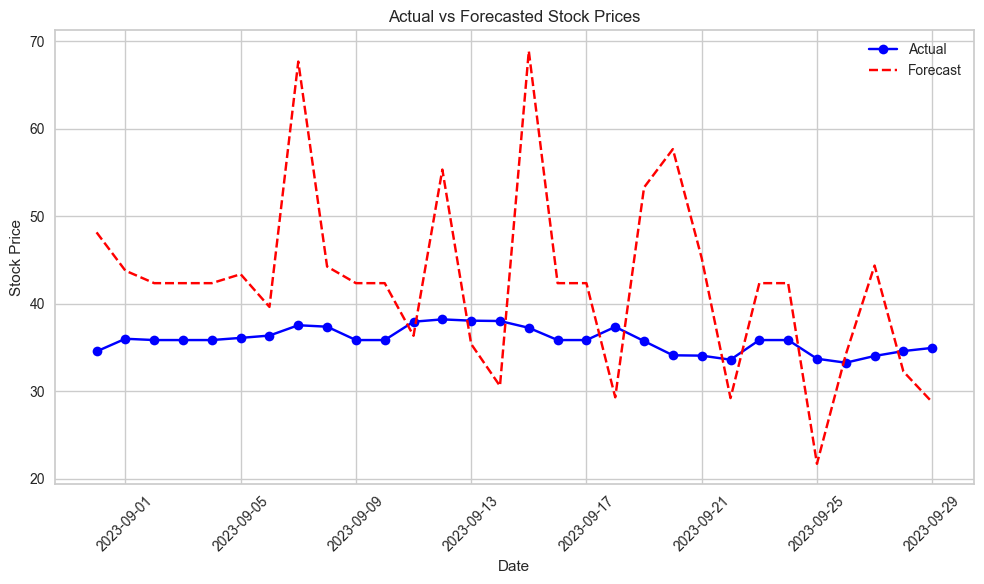

In [ ]:
# Exogenous variables for prediction (using both AMD and Intel for forecasting)
exog_test = test_data[exogenous_features].tail(30)
exog_test = exog_test.fillna(exog_test.mean())

# Make predictions
forecast = predict_model(final_model, fh=30, X=exog_test)

# Transform the values for plotting
actual_values = test_data['adj_close_amd'][-30:].values.flatten()
actual_values_series = pd.Series(actual_values)
actual_values = actual_values_series.fillna(actual_values_series.mean())
Pycaret_Predictions = forecast['y_pred'].values.flatten() / 1000000

# Convert the Period index to DatetimeIndex for plotting
dates = test_data.index[-30:].to_timestamp()  # Convert Period to DatetimeIndex

# Plotting the actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(dates, actual_values, label='Actual', color='blue', marker='o')  # Actual values in blue
plt.plot(dates, Pycaret_Predictions, label='Forecast', color='red', linestyle='--', marker='x')  # Forecast values in red

# Adding labels and title
plt.title('Actual vs Forecasted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Display the plot
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()

In [21]:
#save_model(final_model, './Models/PycaretAMD_Adj_Close')

# 3 AWS DeepAR Model

## Setting up the buckets

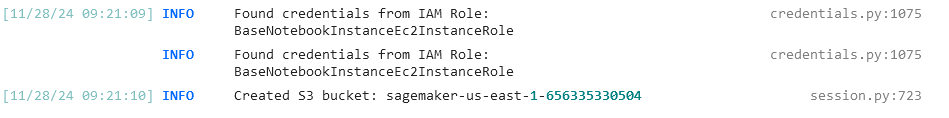

## Setting up the data

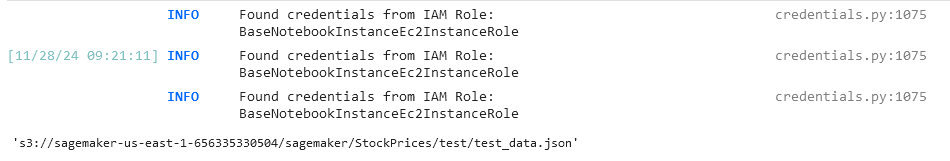

## Building the model and training it

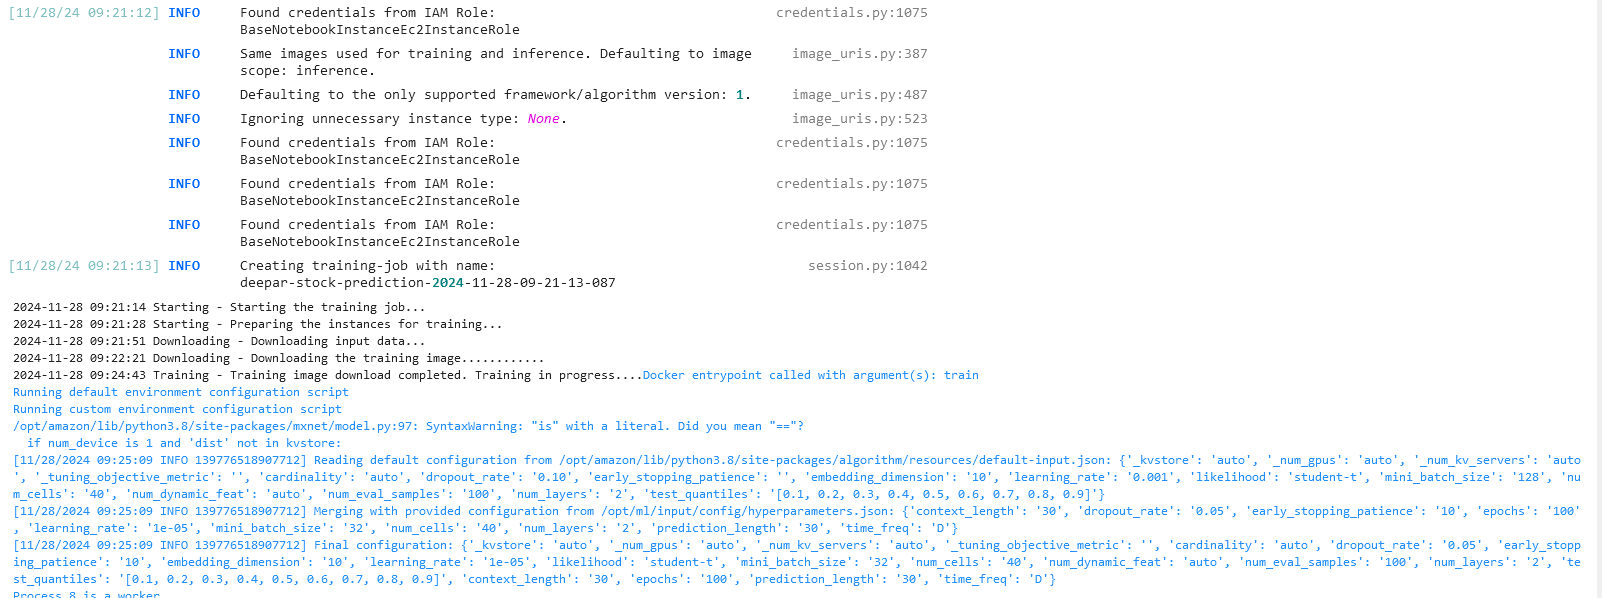

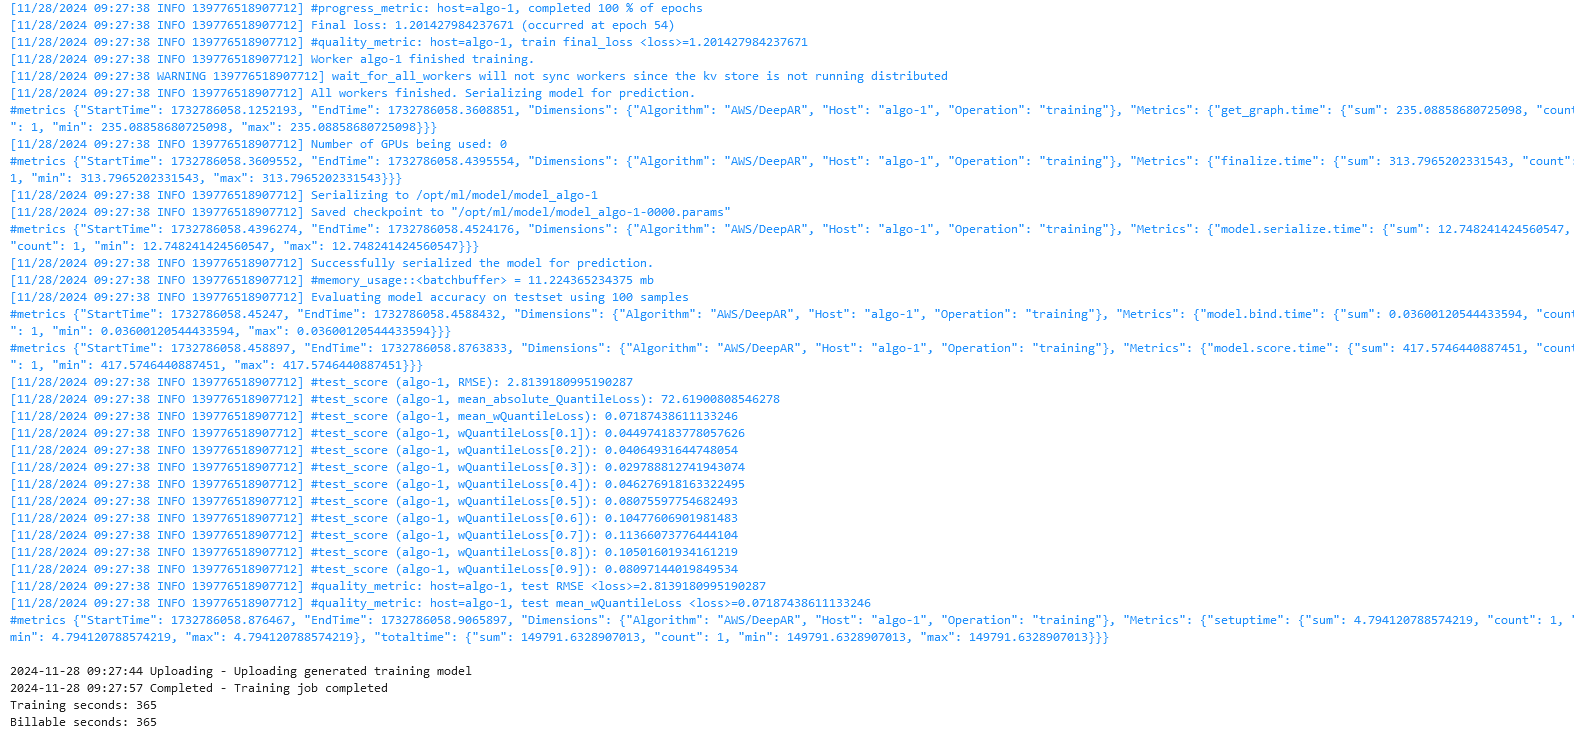

## Deploying the model and predicting

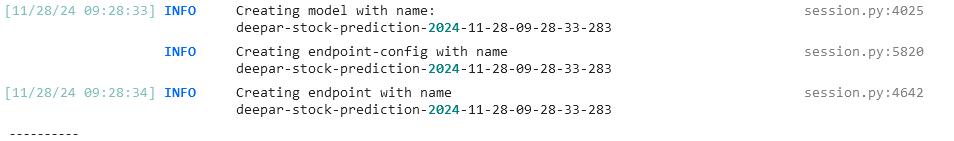

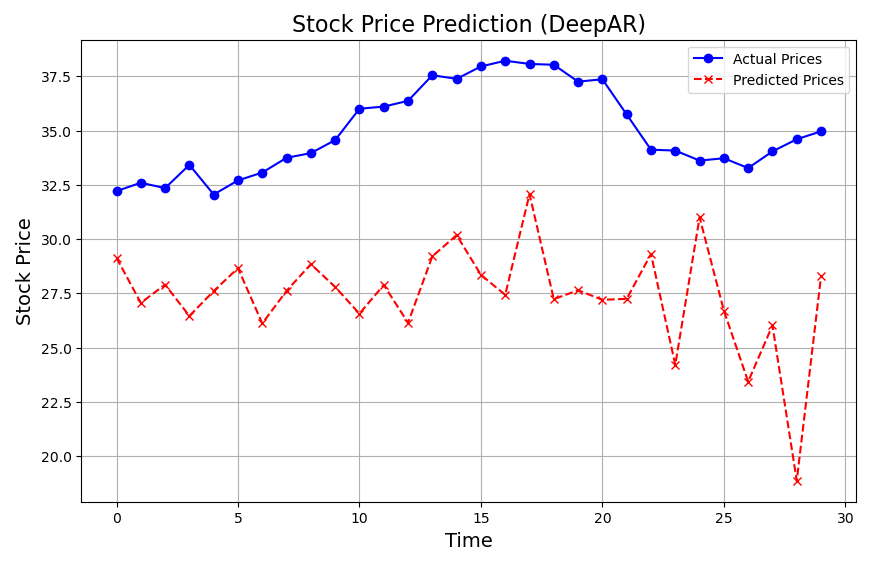

# 4 Comparing the models

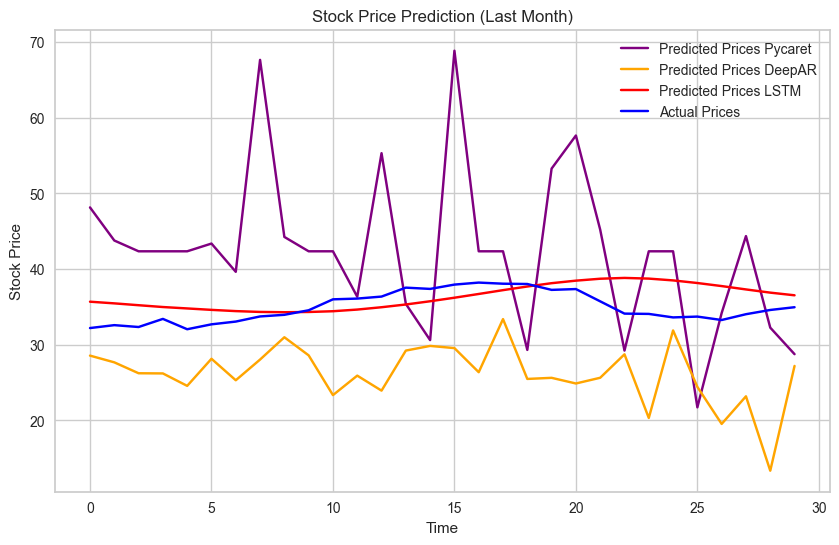

In [ ]:
# Read the preditions previosly saved fromt the DeepAR model.
DeepAR_prediction = pd.read_csv('./Data/DeepAR_prediction_values.csv')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Pycaret_Predictions, label='Predicted Prices Pycaret', color='purple')
plt.plot(DeepAR_prediction, label='Predicted Prices DeepAR', color='orange')
plt.plot(predictions_LSTM, color='red', label='Predicted Prices LSTM')
plt.plot(y_test_actual, color='blue', label='Actual Prices')
plt.title('Stock Price Prediction (Last Month)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

As we can see the the only model who somewhat performed well is the LSTM Model, and the DeepAR and Pycaret didn't perform very well. The Pycaret overshoots dramaticly and the DeepAR Undershoots they also behave more erraticly, probably due to the massive spikes and drops that have happend not too long ago.